## Resolvable Steps Analysis

The following code determines the largest number of statistically distinguishable growth effects caused by a select group of guides on any given gene. The group of guides investigated can be varied, and this notebook analyzes maximum resolvable steps achieved by using (i) all guides, (ii) compounding guides, (iii) single guides, and (iv) a subset of compounding guides to form a compact library. The notebook can analyze glucose or glycerol data.  

Last updated by 5 August 2020

Written by Andrew D. Mathis and Ryan M. Otto

## Import useful libraries

In [1]:
import pandas as pd # Data organization
import numpy as np # Data organization
from scipy import stats # Statistical anaysis
import matplotlib.pyplot as plt # Plotting function
import seaborn as sns # Plotting function`
# Renders figures in notebook
%matplotlib inline

## Establish all paths and variables unique to this analysis.

Default values to recreate figures are provided.

In [2]:
guides_path = 'inputs/df_guides_dict.csv' # General path for guides key
df_path = 'outputs/' # Path for data frames output by HiSeq Analysis code
figure_path = 'Figures/' # General path for saving figures

# Choose which media to analyze
media = 'Glu' # 'Glu' or 'Gly' in our data

# List of groups investigate in following code
group_list = ['Full_All', 'Both_Compounding', 'Both_Single', 'Compact_Library']

# Significance threshold for the SGoF metatest
alpha = 0.05

# Date for labeling output
date = '20200923'

## Central Functions for Analysis

## Finding significant differences in growth effect

To identify all resolvable steps between guides, we make all pairwise comparisons bewteen guides using two sample t-tests. Multiple hypothesis correction in the form of sequential goodness-of-fit (SGoF) is utilized to correct for the large numbers of p-values. SGoF performed as described in Carvahal-Rodriguez et al. 2009.

After correcting our significance threshold, the find_path function finds the longest list of guides for which all growth effects are statistically distinguishable from one another. Finally, as there are often multiple, if not a large number of equally long resolvable paths, the resolvable_steps function selects a path from this list that gives the greatest dynamic range of growth effect between the most and least severe guides while maximizing for variance in growth effect between all guides in the path. This function can also plot this chosen path for each gene.

In [3]:
# Performs all meaningful and unique two sample t-tests comparing growth effects for selected guides
# in all genes. Returns the p-values of these t-tests in a grid and a list.
# Input -- growth_effect_dict: Dictionary containing summary stats on all guides for all genes
#          guides_dict: Dictionary containing lists of all guides in each guide group
#          group: Title for the "family" of guides to analyze
# Output -- pvals_grid: 2D guide x guide array of p-values. Value at position [i][j] is the significance of the
#                        two sample independent t-test (i, j). p-values only filled in above the diagonal.
#           pvals_list: 1D list of all p-values calculated
def pairwise_tests(growth_effect_dict, guides_dict, group):
    
    # Initialize output dictionary and list
    pvals_grid = {}
    pvals_list = []
    
    # Pull out relevant data for the chosen group
    df_gene = growth_effect_dict['mean_severe'][guides_dict[group]]
    df_std = growth_effect_dict['std_severe'][guides_dict[group]]
    df_reps = growth_effect_dict['reps_severe'][guides_dict[group]]
 
    for gene in growth_effect_dict['mean_severe'].index: # For all genes

        mask = ~np.isnan(df_gene.loc[gene]) # Mask nans
        inds = df_gene.loc[gene][mask].argsort() # Guide indices sorted by growth effect (slowest growth to fastest)
        guides = inds.index # Guide identities sorted by growth effect
        
        # Pull out mean, standard deviation, and replicates
        sg_mean = df_gene.loc[gene][mask][inds]
        sg_std = df_std.loc[gene][mask][inds]
        sg_reps = df_reps.loc[gene][mask][inds]

        pvals_grid[gene] = np.zeros((len(guides), len(guides))) # Set upgrid for pairwise comparisons between guides

        for i, guide1 in enumerate(guides): # For every guide
            for j, guide2 in enumerate(guides[i+1:]): # Only run comparisons for guides where index i < index j
                j = j + i + 1 # Fix indexing of the sliced list to be compatible with the original list
                guide1_mean = sg_mean[i]
                guide1_std = sg_std[i]
                guide1_reps = sg_reps[i]
                guide2_mean = sg_mean[j]
                guide2_std = sg_std[j]
                guide2_reps = sg_reps[j]
                
                # Perform a two sample t-test between guides using summary stats from their barcoded replicates
                t_val, pvals_grid[gene][i][j] = stats.ttest_ind_from_stats(guide1_mean, guide1_std, guide1_reps, \
                                                            guide2_mean, guide2_std, guide2_reps, equal_var=False)
                pvals_list.append(pvals_grid[gene][i][j])
    pvals_list.sort() # Sort smallest to largest pvalues (all pvalues, not just significant ones)
    
    return pvals_grid, pvals_list

# Performs binomial sequential goodness-of-fit, a multiple hypothesis correction procedure for large numbers of 
# hypothesis tests. This function filters p-values that fail to meet a significance threshold or are likely to be
# significant only by chance.
# Input -- growth_effect_dict: Dictionary containing summary stats on all guides for all genes
#          guides_dict: Dictionary containing lists of all guides in each guide group
#          pvals_grid: 2D guide x guide array of p-values. Value at position [i][j] is the significance of the
#                        two sample independent t-test (i, j). p-values only filled in above the diagonal.
#          pvals_list: 1D list of all p-values calculated
#          group: Title for the "family" of guides to analyze
#          alpha: Significance threshold for the entire dataset.
# Output -- pvals_masked: Grid containing only significant p-values following SGoF
#           pvals_bool: Grid indicating if a test was significant (1) or not (0) following SGoF
def binomial_SGoF(growth_effect_dict, guides_dict, pvals_grid, pvals_list, group, alpha=0.05):
    
    # Initialize output dictionaries
    pvals_bool = {}
    pvals_masked = {}
    
    # Pull out relevant data for the chosen group
    df_gene = growth_effect_dict['mean_severe'][guides_dict[group]]
    pvals_list = pvals_list[group]
    pvals_grid = pvals_grid[group]

    total_tests = len(pvals_list) # Total tests executed
    sig_tests = sum([x < alpha for x in pvals_list]) # Total significant tests, as determined by alpha

    print('Tests: ' + str(int(total_tests)))
    print('Significant: ' + str(sig_tests))
    
    if total_tests > sig_tests:
        b_sig = 0 # Current number of rejected null hypotheses
        R = sig_tests # Current number of remaining tests to re-check
        
        # Probability that R sig tests could arise from random chance
        p = stats.binom_test(R, n=total_tests, p=alpha, alternative='greater') 
        while p < alpha: # Below our confidence threshold
            b_sig += 1 # Fully reject a null
            R -= 1 # Update remaining tests to re-check
            p = stats.binom_test(R, total_tests, p=alpha, alternative='greater')
    else:
        print('Cannot use SGoF to correct for significance.')
        b_sig = np.nan

    print('Remaining: ' + str(b_sig))
    print('pval_cutoff: ' + str(pvals_list[b_sig]))

    for gene in growth_effect_dict['mean_severe'].index: # For all genes

        mask = ~np.isnan(df_gene.loc[gene]) # Mask nans
        inds = df_gene.loc[gene][mask].argsort() # Guide indices sorted by growth effect (slowest growth to fastest)
        guides = inds.index # Guide identities sorted by growth effect
        
        # Initialize output arrays
        pvals_bool[gene] = np.zeros((len(guides), len(guides)))
        pvals_masked[gene] = np.zeros((len(guides), len(guides)))
        
        for row, array in enumerate(pvals_grid[gene]):
            for col, pval in enumerate(array):
                if (pval < pvals_list[b_sig]) and (pval != 0): # p-values only kept when lower than the cutoff
                    pvals_masked[gene][row][col] = pval # Grid of significant p-values following SGoF
                    pvals_bool[gene][row][col] = 1 # Grid indicating if a test was significant or not following SGoF
    
    return pvals_masked, pvals_bool

### Path finding

Find the longest list of guide RNAs targeting a single gene that give unique growth effects, termed a "path". If ties in length are found, record all potential longest paths.

Given: A strictly increasing list of growth effects and standard deviations 

<center> ($G_{1}$, $G_{2}$, ..., $G_{n}$) = $G_{all}$ </center>

Find: The longest list of strictly increasing growth effects drawn from $G_{all}$ with statistically significant changes in growth effect between all sequential positions.

<center> ($g_{1}$, $g_{2}$, ..., $g_{m}$) = $g_{path}$ </center>


For every $G_{i}$ in $G_{all}$, there exists at least one list of strictly increasing growth effects drawn from $G_{all}$ and starting from $G_{i}$ with statistically significant changes in growth effect between all sequential positions. The longest possible list fulfilling these requirements can be defined as:

<center> $G_{i, path}$ = ($G_{i}$, ...) </center>

$G_{all, path}$ is the complete set of $G_{i, path}$ for $G_{i}$ in $G_{all}$.

For all $G_{i}$, $G_{i,path}$ either (1) stops after $G_{i}$ if no $G_{j}$ exists that is significantly greater than $G_{i}$ or (2) continues to $G_{j}$ if there exists at least one $G_{j}$ that is significantly greater than $G_{i}$.

Assuming $G_{i,path}$ = ($G_{i}$, $G_{j}$, ...), as $G_{i,path}$ is maximized for length starting from $G_{i}$, the trailing sublist ($G_{j}$, ...) must be maximized for length starting from $G_{j}$. Thus:
<center> $G_{i,path}$ = ($G_{i}$, $G_{j,path}$) </center>

And so, if paths for all growth effects significantly greater than $G_{i}$ are known, $G_{i,path}$ is known.

If $G_{n}$ is the greatest growth effect in $G_{all}$, no growth effects are significantly greater than $G_{n}$ and 

<center> $G_{n,path}$ = ($G_{n}$) </center>

To find $G_{n-1,path}$:

If $G_{n}$ is significantly greater than $G_{n-1}$:

<center> $G_{n-1,path}$ = ($G_{n-1}$, $G_{n,path}$) = ($G_{n-1}$, $G_{n}$) </center>

If $G_{n}$ is not significantly greater than $G_{n-1}$:

<center> $G_{n-1,path}$ = ($G_{n-1}$) </center>

For $G_{n-2}$:

<center> $G_{n-2,path}$ = ($G_{n-2}$, $G_{max,path}$) </center>

Where $G_{max,path}$ is the longest path starting from a growth effect that is significantly larger than $G_{n-2}$. If no such growth effect exists, $G_{max,path}$ is empty and:

<center> $G_{n-2,path}$ = ($G_{n-2}$) </center>

Working backwards from n, with this logic we can solve for all paths in $G_{all,path}$.

As all $g_{i}$ in $g_{path}$ are drawn from $G_{all}$, $g_{1}$ is in $G_{all}$. As $g_{path}$ has the same restrictions as $G_{i,path}$, there exists $G_{i}$ where $g_{1}$ = $G_{i}$ and:

<center> $g_{path}$ = $G_{i,path}$ </center>

Thus, $g_{path}$ is in $G_{all,path}$ and is the longest path in $G_{all,path}$.


In [4]:
# Finds the maximum number of resolvable steps (significant changes in growth effect between guides) for every gene.
# When multiple combinations of guides achieve this maximal length, returns all possibilities.
# Input -- growth_effect_dict: Dictionary containing summary stats on all guides for all genes
#          guides_dict: Dictionary containing lists of all guides in each guide group
#          pvals_bool: Grid indicating if a test was significant (1) or not (0) following SGoF
#          group: Title for the "family" of guides to analyze
# Output -- max_path: Dictionary containing all longest paths for each gene
#           max_path_len: Dictionary containing length of the longest path for each gene
def find_path(growth_effect_dict, guides_dict, pvals_bool, group):
    # Initialize output dictionaries
    max_path = {}
    max_path_len = {}
    
    # Initialize temporary dictionary
    guide_paths = {}
    
    # Pull out relevant data for the chosen group
    df_gene = growth_effect_dict['mean_severe'][guides_dict[group]]
    pvals_bool = pvals_bool[group]

    for gene in growth_effect_dict['mean_severe'].index: # For all genes
        
        # Set up everything for given gene
        guide_paths[gene] = {}
        mask = ~np.isnan(df_gene.loc[gene]) # Mask nans
        inds = df_gene.loc[gene][mask].argsort() # Guide indices sorted by growth effect (slowest growth to fastest)
        guides = inds.index # Guide identities sorted by growth effect
        
        index_range = range(len(guides)) # Index vector across all guides

        # Find the best path starting at each guide
        for i in index_range[::-1]: # Counting backwards (i is the current index)
            
            temp_guide_path = [[]] # Initial best path following i, double brackets are necessary
            temp_guide_path_len = 0 # Initial best length following i
            
            for j in index_range[i+1:]: # Look only at guides after i (where j is the index of the compared guide)
                
                if pvals_bool[gene][i][j] == 1: # Significant difference following SGoF
                    
                    if len(guide_paths[gene][j][0]) > temp_guide_path_len: # Update if path of guide j is the longest
                        temp_guide_path = guide_paths[gene][j] # Update longest path
                        temp_guide_path_len = len(guide_paths[gene][j][0]) # Update longest length
                        
                    elif (len(guide_paths[gene][j][0]) == temp_guide_path_len): # Ties in length are included
                        temp_guide_path += guide_paths[gene][j]

            guide_paths[gene][i] = [[i] + x for x in temp_guide_path] # Append i to the front of all paths
    # Select the best path for each gene, regardless of which guide it starts from
    for gene in growth_effect_dict['mean_severe'].index: # For each gene
        
        temp_max_path = [] # Initial best path
        temp_max_len = 0 # Initial best length

        for i in guide_paths[gene].keys(): # For each guide
            
            if len(guide_paths[gene][i][0]) > temp_max_len: # Update if path of guide i is the longest
                temp_max_path = guide_paths[gene][i] # Update longest path
                temp_max_len = len(guide_paths[gene][i][0]) # Update longest length
                
            elif len(guide_paths[gene][i][0]) == temp_max_len: # Ties in length are included
                temp_max_path += guide_paths[gene][i]

        max_path[gene] = temp_max_path # Finalize longest path
        max_path_len[gene] = temp_max_len # Finalize longest length

    print('Average resolvable steps for ' + group + ' guides: ' + str(np.mean(max_path_len.values())))
    
    return max_path, max_path_len

### Select optimal path of resolvable changes in growth effect

Selects the single best path of resolvable steps for a selected gene and guide group. To determine the "best" path in cases where there are ties, the function first filters paths to maximize the dynamic range of the set of guides (maximum growth effect - minimum growth effect). Following filtering, the function selects the path with the  greatest variance in growth effect. 

In [5]:
# Selects the optimal path out of a list of paths of equal, maximal length. Function can also plot this path to
# visualize the resolvable changes in growth effect.
# Input -- growth_effect_dict: Dictionary containing summary stats on all guides for all genes
#          guides_dict: Dictionary containing lists of all guides in each guide group
#          max_path: Dictionary containing all longest paths for every gene
#          group: Title for the "family" of guides to analyze
#          gene: Selected gene of interest for path optimization and plotting
#          figure_path: Path for saving figures
#          date: Date stamp for output files
#          plot: Boolean option to display all growth effects in the group, highlighting the optimal path
# Output -- best_guide_path: Ordered list of guides that make up the optimal path for the selected gene
#           best_growth_path: Ordered list of growth effects that make up the optimal path for the selected gene
def resolvable_steps(growth_effect_dict, guides_dict, max_path, group, gene, figure_path, date, plot=True):

    # Pull out relevant data for the chosen group
    df_gene = growth_effect_dict['mean_severe'][guides_dict[group]]
    df_sem = growth_effect_dict['sem_severe'][guides_dict[group]]
    max_path = max_path[group]
    
    if len(max_path[gene]) != 0: # If no guides from a group were designed for this gene, max_path[gene] = []

        # Set up everything for the given gene
        mask = ~np.isnan(df_gene.loc[gene]) # Mask nans
        inds = df_gene.loc[gene][mask].argsort() # Guide indices sorted by growth effect (slowest growth to fastest)
        guides = inds.index # Guide identities sorted by growth effect
        
        sg_mean = df_gene.loc[gene][mask][inds]
        sg_sem = df_sem.loc[gene][mask][inds]

        max_dyn = -np.inf # Initial maximum dynamic range
        max_var = -np.inf # Initial maximum variance
        
        for i, index_path in enumerate(max_path[gene]): # For all max-length paths from a given gene
            
            temp_dyn = sg_mean[index_path[-1]] - sg_mean[index_path[0]] # Efficiently measure dynamic range
            
            # Reassign all variables for new maximum dynamic range
            if temp_dyn > max_dyn:
                growth_path = [sg_mean[x] for x in index_path] # Deconvolute indices to growth rate
                max_dyn = temp_dyn
                max_var = np.var(growth_path)
                best_growth_path = growth_path
                best_index_path = index_path
              
            # Reassign all variables for tied maximum dynamic range and new maximum variance
            elif temp_dyn == max_dyn:
                growth_path = [sg_mean[x] for x in index_path] # Deconvolute indices to growth rate
                temp_var = np.var(growth_path)
                if temp_var > max_var:
                    max_dyn = temp_dyn
                    max_var = temp_var
                    best_growth_path = growth_path
                    best_index_path = index_path
               
        best_guide_path = [sg_mean.index[x] for x in best_index_path] # Deconvolute indices to guide name
        
        if plot: # Boolean argument check
            # Plot initialization
            fig, ax = plt.subplots(1, 1, figsize = (3, 3))
            # Plot all guides in gray
            ax.errorbar(sg_mean.keys(), sg_mean, yerr=sg_sem, fmt='o', color='gray', lw=0.5)
            # Plot optimal path in red
            ax.errorbar(sg_mean.keys()[best_index_path], sg_mean.loc[sg_mean.keys()[best_index_path]], 
                        yerr=sg_sem.loc[sg_mean.keys()[best_index_path]], color='r', fmt='o', lw=0.5)
            ax.set_ylabel('Growth effect', fontsize=12)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.tick_params(axis='y', labelsize=12)
            ax.set_xlabel(str(group) + ' guides', fontsize=12)
            ax.set_title(gene, fontsize=14)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if group == 'Full_All' and gene == 'folA':
                plt.savefig(figure_path + 'r-steps/' + date + '_resolvable_steps_' + group + '_' + gene + 
                            '_Fig4C.pdf', transparent=True)
            else:
                plt.savefig(figure_path + 'r-steps/' + date + '_resolvable_steps_' + group + '_' + gene + '.pdf', 
                            transparent=True)
            plt.show()

        return best_guide_path, best_growth_path
    
    return [], [] # If no guides from a group were designed for this gene, return empty lists


## Import, filter, and normalize data

In [6]:
# Links group name to guide identity
guides_dict = {}
df_guides_dict = pd.read_csv(guides_path)
for key in df_guides_dict:
    guides_dict[key] = df_guides_dict[key].values[[str(x) != 'nan' for x in \
                                                   df_guides_dict[key].values.tolist()]].tolist()

# Import the growth effect data (negC = 1, cell death = 0)
growth_effect_dict = {}
growth_effect_dict['mean'] = pd.read_csv(df_path + '20200923_df_growth_effect_' + media + '.csv', 
                                         index_col=0, parse_dates=True)
growth_effect_dict['std'] = pd.read_csv(df_path + '20200923_df_growth_effect_std_' + media + '.csv', 
                                        index_col=0, parse_dates=True)
growth_effect_dict['sem'] = pd.read_csv(df_path + '20200923_df_growth_effect_sem_' + media + '.csv', 
                                        index_col=0, parse_dates=True)

# Import the number of replicates for each guide
growth_effect_dict['reps'] = pd.read_csv(df_path + '20200923_df_reorder_N_' + media + '.csv', 
                                         index_col=0, parse_dates=True)

# Filter to only consider genes with an on-target (SG1, SG2, or SG3) growth effect less than 0.75
# Without meeting this criteria, reasonable changes in growth effect are either absent or potentially the 
# product of off-target binding.
SG1_growth_filter = growth_effect_dict['mean']['1_C_C'] < 0.75
SG2_growth_filter = growth_effect_dict['mean']['2_C_C'] < 0.75
SG3_growth_filter = growth_effect_dict['mean']['3_C_C'] < 0.75

growth_mask = [any(tup) for tup in zip(SG1_growth_filter, SG2_growth_filter, SG3_growth_filter)]

# Filter to only consider genes where we could design both SG1 and SG3
# Genes missing one of these guide families aren't statistically comprable to the rest of the set
SG1_present_filter = []
SG3_present_filter = []
for gene in growth_effect_dict['mean'].index:
    SG1_present_filter.append(any(~np.isnan(growth_effect_dict['mean'][guides_dict['SG1_All']].loc[gene])))
    SG3_present_filter.append(any(~np.isnan(growth_effect_dict['mean'][guides_dict['SG3_All']].loc[gene])))

present_mask = [all(tup) for tup in zip(SG1_present_filter, SG3_present_filter)] # Both SG1-based and SG3-based guides

total_mask = [all(tup) for tup in zip(growth_mask, present_mask)] # Genes passing both previous filters

growth_effect_dict['mean_severe'] = growth_effect_dict['mean'][total_mask]
growth_effect_dict['std_severe'] = growth_effect_dict['std'][total_mask]
growth_effect_dict['sem_severe'] = growth_effect_dict['sem'][total_mask]
growth_effect_dict['reps_severe'] = growth_effect_dict['reps'][total_mask]

# Normalize data by SG1 on-target growth effect for some data visualization
df_SG1_norm = growth_effect_dict['mean_severe'].T.sub(growth_effect_dict['mean_severe']['1_C_C']).T

## Data visualization

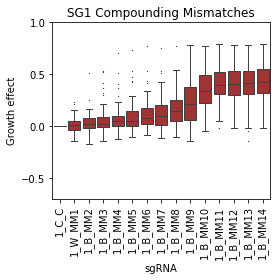

In [7]:
# Figure S6D Part 1
# Plots the change in growth effect as compounding mismatches are added to parent sgRNA 1
# Deviation from 0.0 indicates the change in growth effect from the growth effect of parent sgRNA 1 for the same gene
plt.figure(figsize = (4, 4))

sns.boxplot(data=df_SG1_norm.T[0:15].T, zorder=2, showfliers=True, color='firebrick', fliersize=0.4, linewidth=1)

plt.xticks(rotation=90)
plt.yticks([-0.5, 0, 0.5, 1])
plt.ylim(-0.7, 1)
plt.title('SG1 Compounding Mismatches')
plt.xlabel('sgRNA')
plt.ylabel('Growth effect')
plt.tight_layout()
plt.savefig(figure_path + date + '_CRISPRi_activity_C1_FigS6D.pdf', transparent=True)
plt.show()

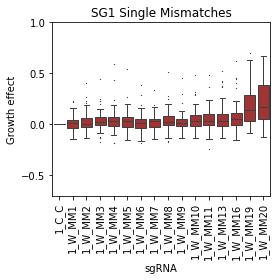

In [8]:
# Plots the change in growth effect as single mismatches are added to parent sgRNA 1
# Deviation from 0.0 indicates the change in growth effect from the growth effect of parent sgRNA 1 for the same gene
plt.figure(figsize=(4, 4))

data = pd.concat([df_SG1_norm.T[0:2], df_SG1_norm.T[15:29]]).T
sns.boxplot(data=data, zorder=2, showfliers=True, color='firebrick', fliersize=.4, linewidth=1)

plt.xticks(rotation=90)
plt.yticks([-0.5, 0, 0.5, 1])
plt.ylim(-0.7, 1)
plt.title('SG1 Single Mismatches')
plt.xlabel('sgRNA')
plt.ylabel('Growth effect')
plt.tight_layout()
plt.savefig(figure_path + date + '_CRISPRi_activity_S1.pdf', transparent=True)
plt.show()

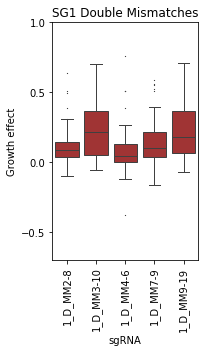

In [9]:
# Plots the change in growth effect as double mismatches are added to parent sgRNA 1
# Deviation from 0.0 indicates the change in growth effect from the growth effect of parent sgRNA 1 for the same gene
plt.figure(figsize=(3, 5))

sns.boxplot(data=df_SG1_norm.T[29:34].T, zorder=2, showfliers=True, color='firebrick', fliersize=0.4, linewidth=1)

plt.xticks(rotation=90)
plt.yticks([-0.5, 0, 0.5, 1])
plt.ylim(-0.7, 1)
plt.title('SG1 Double Mismatches')
plt.xlabel('sgRNA')
plt.ylabel('Growth effect')
plt.tight_layout()
plt.savefig(figure_path + date + '_CRISPRi_activity_D1.pdf', transparent=True)
plt.show()

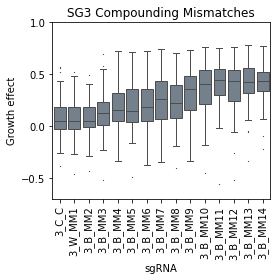

In [10]:
# Figure S6D Part 2
# Plots the change in growth effect as compounding mismatches are added to parent sgRNA 1
# Deviation from 0.0 indicates the change in growth effect from the growth effect of parent sgRNA 1 for the same gene
plt.figure(figsize=(4, 4))

sns.boxplot(data=df_SG1_norm.T[35:50].T, zorder=2, showfliers=True, color='slategrey', fliersize=0.4, linewidth=1)

plt.xticks(rotation=90)
plt.yticks([-0.5, 0, 0.5, 1])
plt.ylim(-0.7, 1)
plt.title('SG3 Compounding Mismatches')
plt.xlabel('sgRNA')
plt.ylabel('Growth effect')
plt.tight_layout()
plt.savefig(figure_path + date + '_CRISPRi_activity_C3_FigS6D.pdf', transparent=True)
plt.show()

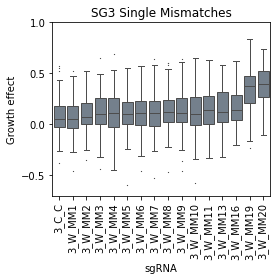

In [11]:
# Plots the change in growth effect as single mismatches are added to parent sgRNA 1
# Deviation from 0.0 indicates the change in growth effect from the growth effect of parent sgRNA 1 for the same gene
plt.figure(figsize=(4, 4))
data = pd.concat([df_SG1_norm.T[35:37], df_SG1_norm.T[50:64]]).T
sns.boxplot(data=data, zorder=2, showfliers=True, color='slategrey', fliersize=0.4, linewidth=1)

plt.xticks(rotation=90)
plt.yticks([-0.5, 0, 0.5, 1])
plt.ylim(-0.7, 1)
plt.title('SG3 Single Mismatches')
plt.xlabel('sgRNA')
plt.ylabel('Growth effect')
plt.tight_layout()
plt.savefig(figure_path + date + '_CRISPRi_activity_S3.pdf', transparent=True)
plt.show()

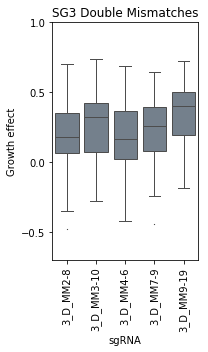

In [12]:
# Plots the change in growth effect as double mismatches are added to parent sgRNA 1
# Deviation from 0.0 indicates the change in growth effect from the growth effect of parent sgRNA 1 for the same gene
plt.figure(figsize=(3, 5))

sns.boxplot(data=df_SG1_norm.T[64:].T, zorder=2, showfliers=True, color='slategrey', fliersize=0.4, linewidth=1)

plt.xticks(rotation=90)
plt.yticks([-0.5, 0, 0.5, 1])
plt.ylim(-0.7, 1)
plt.title('SG3 Double Mismatches')
plt.xlabel('sgRNA')
plt.ylabel('Growth effect')
plt.tight_layout()
plt.savefig(figure_path + date + '_CRISPRi_activity_D3.pdf', transparent=True)
plt.show()

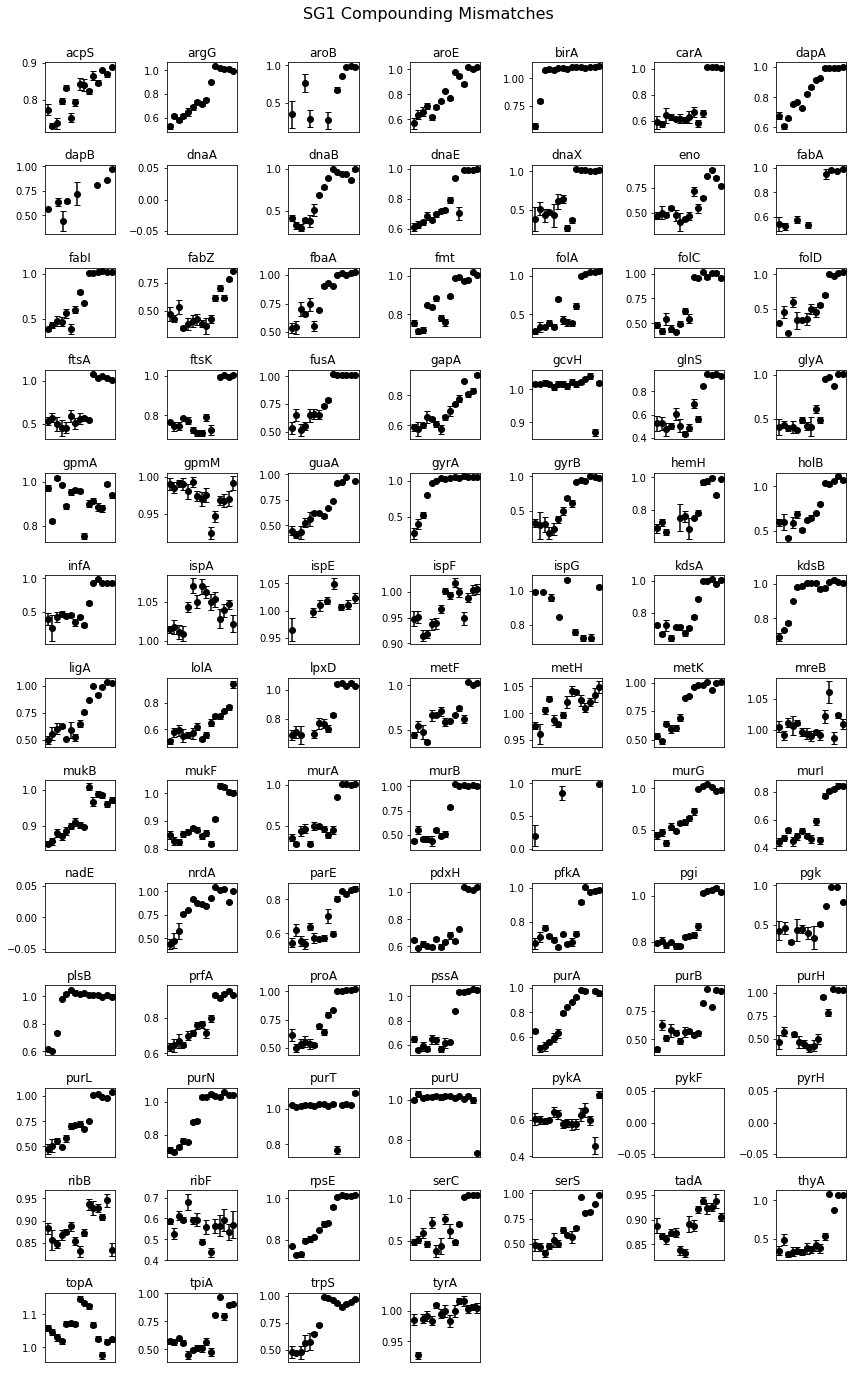

In [13]:
# Plots growth effect across all compounding mismatch guides from parent SG1
plt.figure(figsize=(12, 20))

for i, gene in enumerate(growth_effect_dict['mean'].index):
    plt.subplot(14, 7, i+1)
    y = growth_effect_dict['mean'].T[0:15][gene]
    yerr = growth_effect_dict['sem'].T[0:15][gene]
    x = np.arange(len(y))
    plt.errorbar(x, y, yerr=yerr, fmt='ok', capsize=3)
    plt.xticks([])
    plt.title(gene)
plt.suptitle('SG1 Compounding Mismatches', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

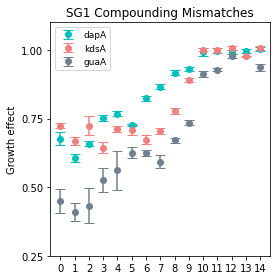

In [14]:
# Figure 4A
# Plots growth effect as compounding mismatches are added to parent sgRNA 1 for three example genes
# The change in growth rate is relatively monotonic and shows a range growth effects
plt.figure(figsize=(4, 4))

gene_sel = ['dapA', 'kdsA', 'guaA'] # Select list of example genes
colors = ['c', 'lightcoral', 'slategrey']

for i, gene in enumerate(gene_sel):
    y = growth_effect_dict['mean'].T[0:15][gene]
    yerr = growth_effect_dict['sem'].T[0:15][gene]
    x = np.arange(len(y))
    plt.errorbar(x, y, yerr=yerr, fmt='o', c=colors[i], capsize=5, label=gene)
    plt.xticks(np.arange(0, 15))
    plt.yticks(np.arange(0.25, 1.1, 0.25))
    plt.ylim([0.25, 1.1])
    
plt.legend(prop={'size': 9})
plt.title('SG1 Compounding Mismatches')
plt.ylabel('Growth effect')
plt.tight_layout()
plt.savefig(figure_path + date + '_comp_exp_Fig4A.pdf', transparent=True)
plt.show()

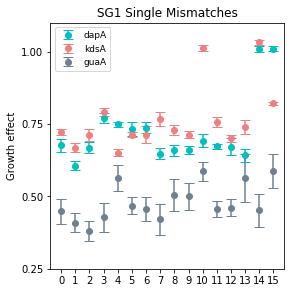

In [15]:
# Figure 4B
# Plots growth effect as single mismatches are added to parent sgRNA 1 for three example genes
# The change in growth rate is nonmonotonic fails to show a range of growth effects
plt.figure(figsize=(4, 4))

# Pull single mismatch data
df_S1 = pd.concat([growth_effect_dict['mean'].T[0:2] , growth_effect_dict['mean'].T[15:29]])
df_S1_err = pd.concat([growth_effect_dict['sem'].T[0:2] , growth_effect_dict['sem'].T[15:29]])

for i, gene in enumerate(gene_sel):
    y = df_S1[gene]
    yerr = df_S1_err[gene]
    x = np.arange(len(y))
    plt.errorbar(x, y, yerr=yerr, fmt='o', c=colors[i], capsize=5, label=gene)
    plt.xticks(np.arange(len(y)))
    plt.yticks(np.arange(0.25, 1.1, 0.25))
    plt.ylim([0.25, 1.1])
    
plt.legend(prop={'size': 9})
plt.tight_layout()
plt.title('SG1 Single Mismatches')
plt.ylabel('Growth effect')
plt.savefig(figure_path + date + '_single_exp_Fig4B.pdf', transparent=True)
plt.show()

## Find all resolvable steps

Iterates through all guide RNA groups, identifies significantly different sgRNA growth effects, and outputs the longest possible path(s) of unique growth effects for each gene. The corrected cutoff following SGoF is printed as pval_cutoff. In all instances of our data, a corrected p-value between 0.02 and 0.03 was sufficient to trim potential false positives. Analysis occurs over "groups" or subsets of guides. Identities of guides found in each group can be found in guides_dict, and each group is defined briefly below.


Full_All         -- all guides in the set, including SG2. Not defined as "Both_All" to ensure SG2 is noted

Both_Compounding -- all compounding mismatches from SG1 and SG3, including parents

Both_Single      -- all single mismatches from SG1 and SG3, including parents

Compact_Library          -- selected compounding and parent guides for SG1 and SG3

In [16]:
# Initialize all dictionaries
pvals_grid = {}
pvals_list = {}
pvals_masked = {}
pvals_bool = {}
max_path = {}
max_path_len = {}
best_guide_path = {}
best_growth_path = {}

In [17]:
for group in group_list:
    print('Guide Group: ' + group)
    pvals_grid[group], pvals_list[group] = pairwise_tests(growth_effect_dict, guides_dict, group)

    pvals_masked[group], pvals_bool[group] = binomial_SGoF(growth_effect_dict, guides_dict, 
                                                           pvals_grid, pvals_list, group, alpha)

    max_path[group], max_path_len[group] = find_path(growth_effect_dict, guides_dict, pvals_bool, group)
    print('')

Guide Group: Full_All
Tests: 149797
Significant: 102474
Remaining: 94845
pval_cutoff: 0.02296429968472843
Average resolvable steps for Full_All guides: 9.782608695652174

Guide Group: Both_Compounding
Tests: 28091
Significant: 20270
Remaining: 18805
pval_cutoff: 0.019673330778339486
Average resolvable steps for Both_Compounding guides: 7.0

Guide Group: Both_Single
Tests: 31509
Significant: 17137
Remaining: 15498
pval_cutoff: 0.027724830529722588
Average resolvable steps for Both_Single guides: 6.231884057971015

Guide Group: Compact_Library
Tests: 7746
Significant: 5252
Remaining: 4833
pval_cutoff: 0.022321103674802834
Average resolvable steps for Compact_Library guides: 5.27536231884058



## Comparing compounding and single mismatch sgRNA design strategies

Partially mismatched sgRNAs were designed using either a compounding mismatch design strategy or a single mismatch design strategy (a sparse sample of double mismatches were made as well, but these are largely excluded from downstream analysis). Below are histograms describing the number of resolvable steps found across each gene using either one or both of these strategies. The compounding mismatches strategy largely outperforms the single mismatch strategy, even though there are two more guides present in the single mismatch set (Compounding: 30, Single: 32). The complete set of sgRNAs (Full_All) includes guides from both strategies as well as a selection of double mismatch guides and an additional control sgRNA - SG2 (69 guides total). Note: In some cases certain guide families or individual guides could not be designed for a specific gene, which in turn affects the number of resolvable steps seen in our data.

Both_Single 6.2 resolvable steps
Full_All 9.8 resolvable steps
Both_Compounding 7.0 resolvable steps


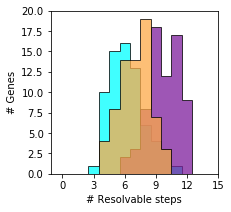

In [18]:
# Figure 4D
plt.figure(figsize = (3, 3))
bins = np.arange(14)
colors = ['xkcd:cyan', 'xkcd:purple', 'xkcd:light orange']
for i, group in enumerate(['Both_Single', 'Full_All', 'Both_Compounding']):
    if group in group_list:
        print(group + ' ' + str(round(np.mean(max_path_len[group].values()), 1)) + ' resolvable steps')
        plt.hist(max_path_len[group].values(), stacked=False, fill=True, histtype='step', bins=bins, 
                 alpha=0.75, edgecolor='k', label=group, color=colors[i])
        plt.xticks(np.array([0, 3, 6, 9, 12, 15]) + 0.5, [0, 3, 6, 9, 12, 15])
        
    plt.xlabel('# Resolvable steps')
    plt.ylabel('# Genes')
    plt.ylim(0, 20)

plt.savefig(figure_path + date + '_Res_steps_comparison_' + group + '_Fig4D.pdf', transparent=True)
plt.show()

## Histograms of all sgRNA design strategies

Similar to the plot above, but each histogram is plotted separately and all sgRNA design groups selected in "group_list" are plotted.

Average resolvable steps for Full_All guides: 9.782608695652174
Min resolvable steps for Full_All guides: 6
Max resolvable steps for Full_All guides: 13



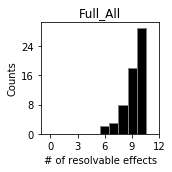

Average resolvable steps for Both_Compounding guides: 7.0
Min resolvable steps for Both_Compounding guides: 4
Max resolvable steps for Both_Compounding guides: 10



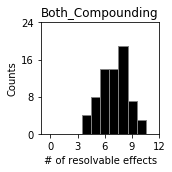

Average resolvable steps for Both_Single guides: 6.231884057971015
Min resolvable steps for Both_Single guides: 3
Max resolvable steps for Both_Single guides: 11



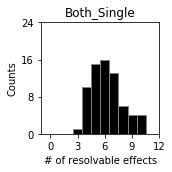

Average resolvable steps for Compact_Library guides: 5.27536231884058
Min resolvable steps for Compact_Library guides: 2
Max resolvable steps for Compact_Library guides: 9



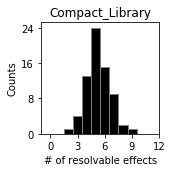

In [19]:
# Figure 4E
for group in group_list:
    plt.figure(figsize = (2.5, 2.5)) # Initialize figure
    bins = np.arange(12)
    plt.hist(max_path_len[group].values(), bins=bins, color='k', edgecolor='grey', alpha=1)
    plt.yticks(np.arange(0, 25, 8))
    plt.xticks(np.array([0, 3, 6, 9, 12]) + 0.5, [0, 3, 6, 9, 12])
    plt.ylabel('Counts')
    plt.xlabel('# of resolvable effects')
    plt.title(group)
    plt.tight_layout()
    print('Average resolvable steps for ' + str(group) + ' guides: ' + str(np.mean(max_path_len[group].values())))
    print('Min resolvable steps for ' + str(group) + ' guides: ' + str(np.amin(max_path_len[group].values())))
    print('Max resolvable steps for ' + str(group) + ' guides: ' + str(np.amax(max_path_len[group].values())))
    print('')
    if group == 'Compact_Library':
        plt.savefig(figure_path + date + '_select_hist_' + group + '_Fig4E.pdf', transparent=True)
    else:
        plt.savefig(figure_path + date + '_select_hist_' + group + '.pdf', transparent=True)
    plt.show()

## Finding the single optimal path of resolvable sgRNA growth effects

As there are often many possible ways to achieve the maximum number of resolvable sgRNA growth effects across a selection of guides, a strategy was created to determine a unique path for each gene to optimize their use in experiments. Our first priority when dealing with redundancy was to maximize the dynamic range of our guide path, to allow for the greatest absolute change in growth effect across the guide selection. However, even after filtering for paths that achieve this maximal range, alternative pathways between the miminum and maximum growth effects often persist. To finish, we select the path with the greatest variance in growth effect, which provides a single unique path for all genes (note: this method assumes that at least two resolvable growth effects are found).

If the final argument in resolvable_steps is set to True, this will also plot the growth effects and standard errors of this optimal path in relation to all guides not part of the final path. With this, we see that our strategy selects guide paths that cover the vast majority of potential growth effects.

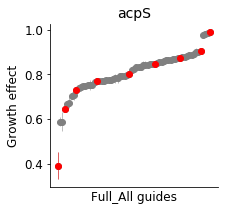

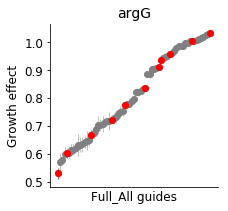

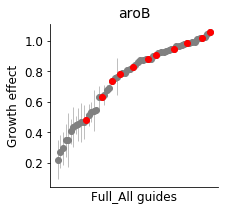

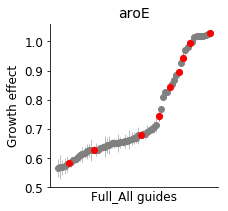

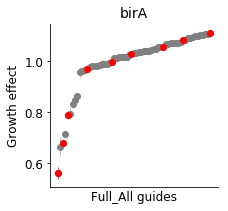

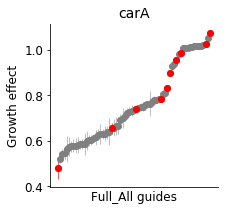

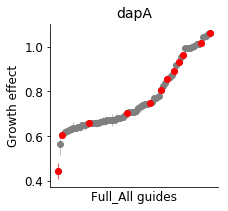

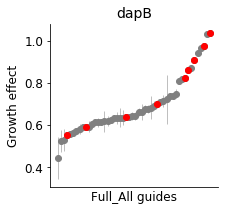

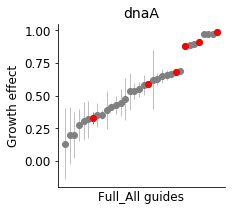

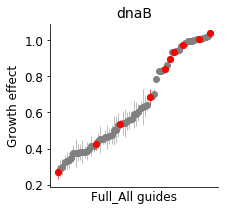

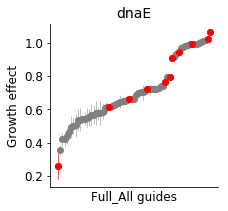

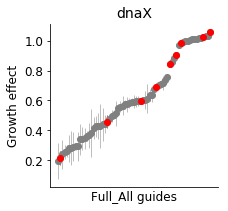

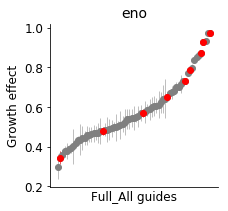

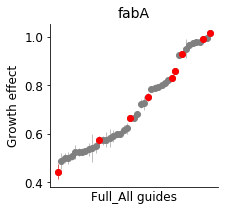

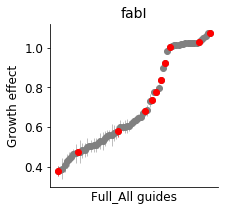

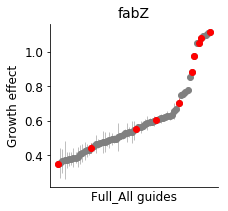

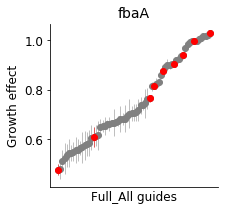

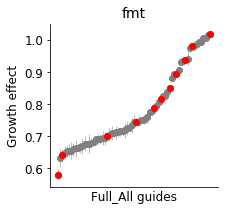

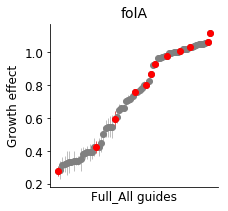

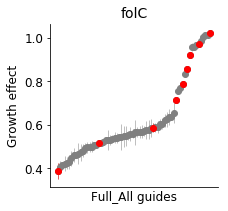

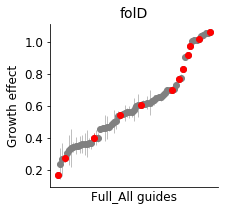

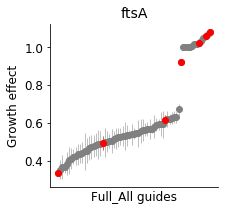

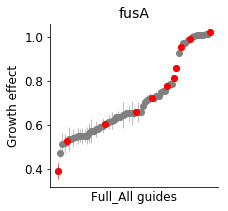

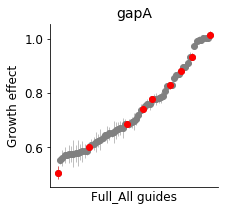

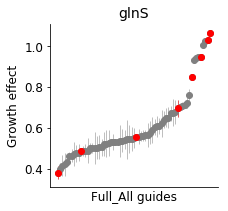

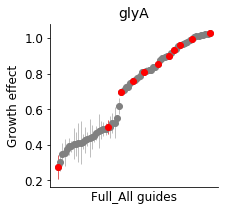

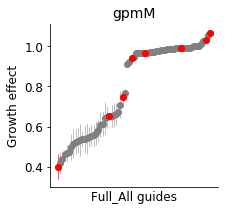

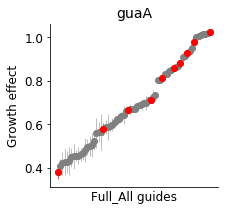

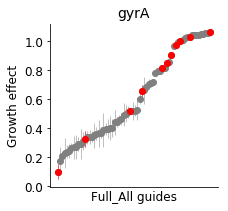

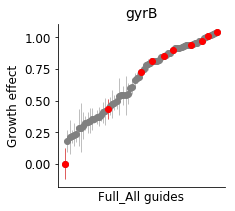

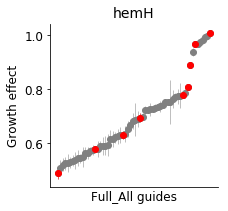

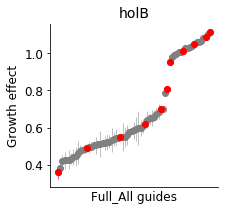

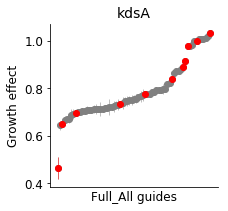

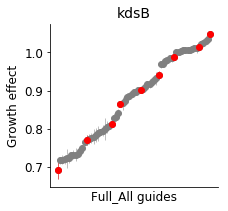

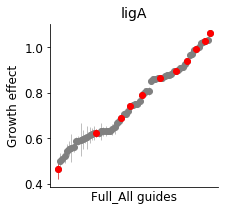

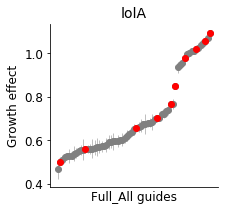

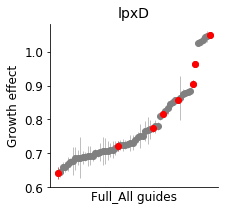

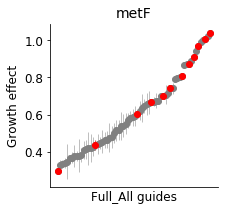

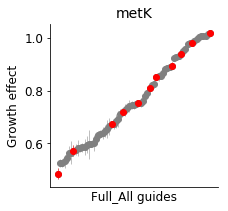

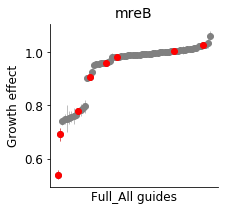

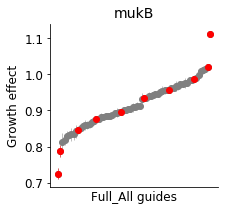

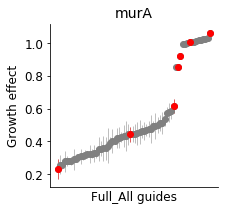

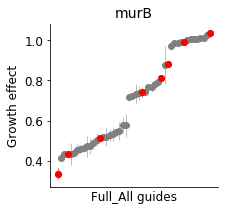

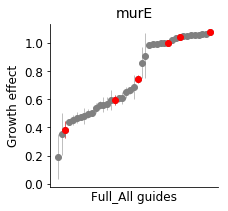

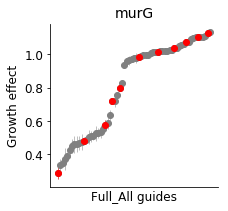

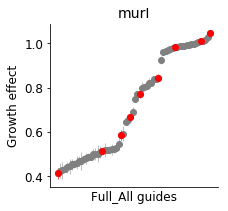

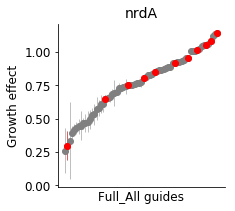

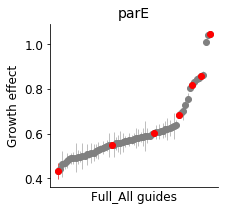

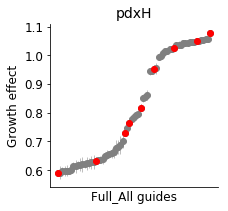

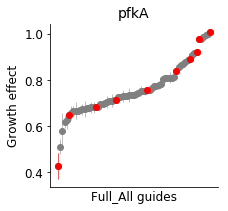

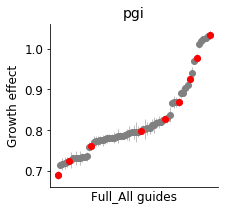

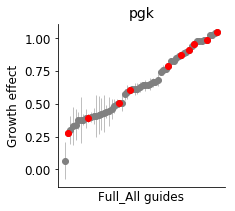

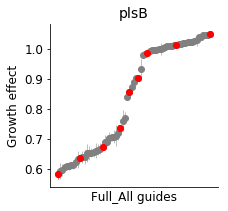

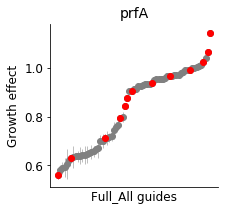

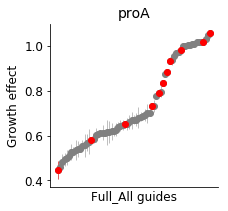

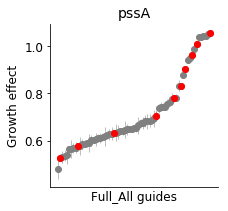

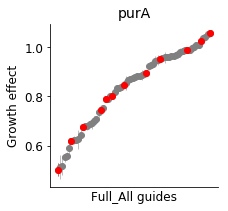

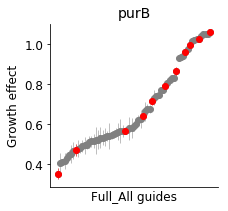

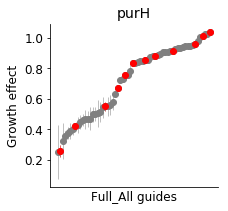

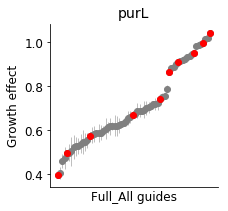

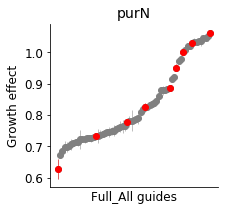

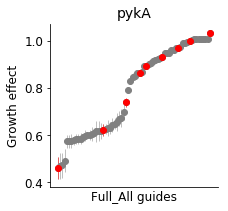

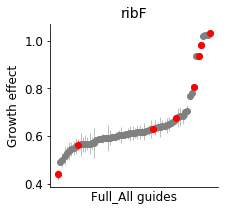

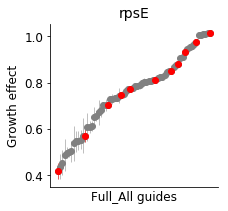

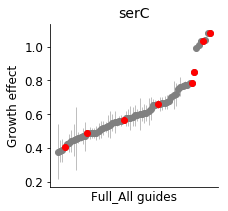

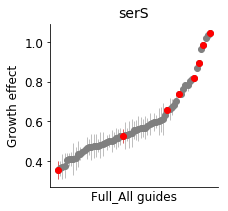

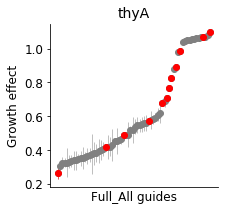

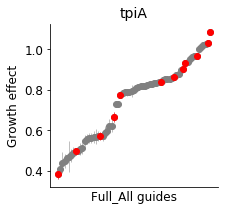

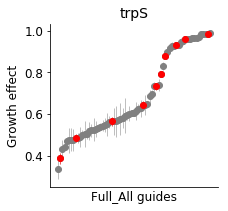

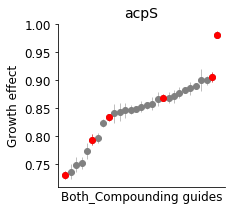

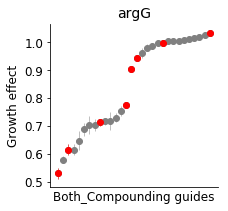

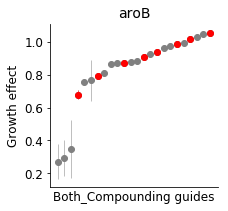

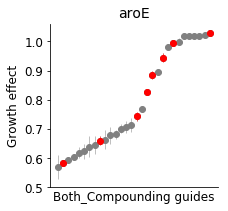

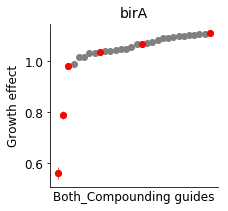

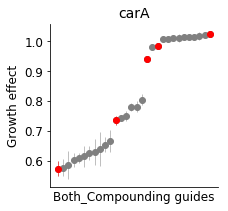

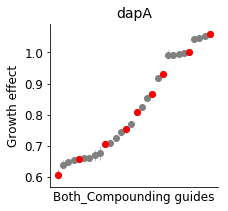

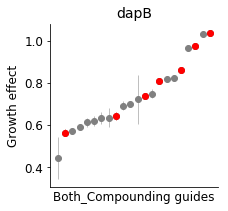

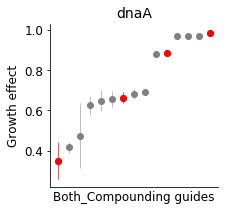

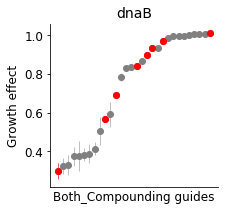

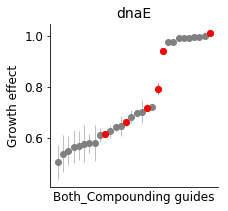

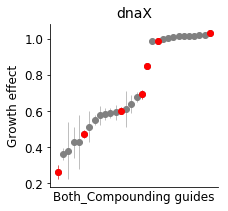

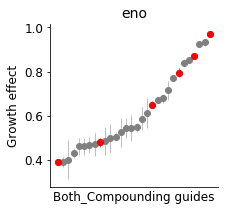

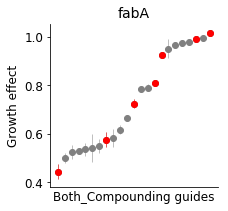

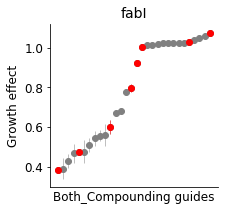

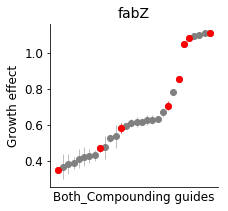

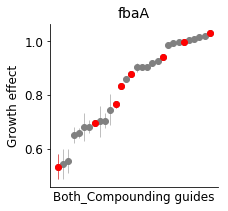

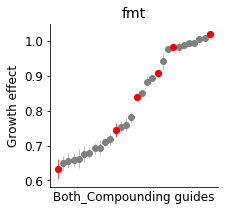

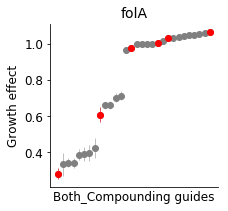

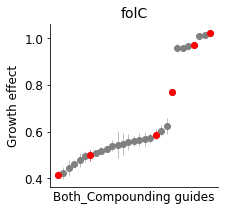

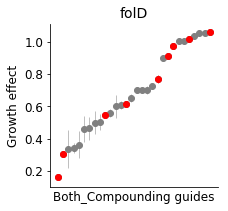

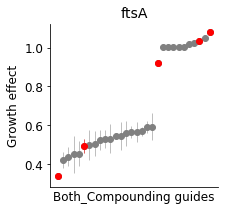

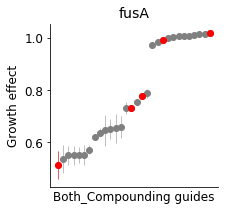

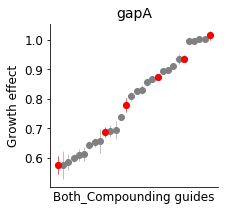

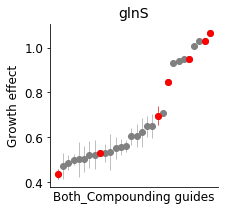

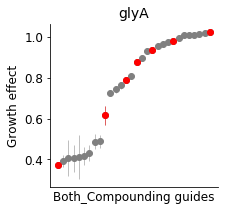

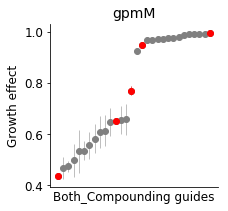

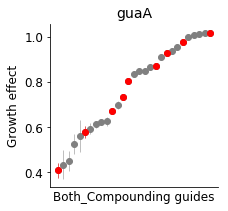

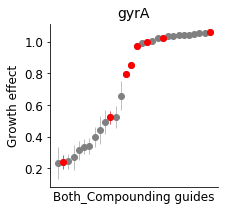

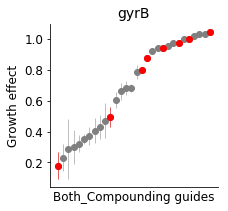

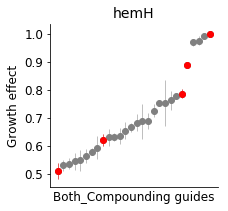

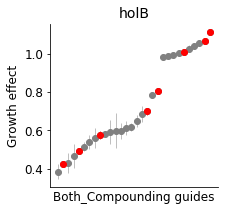

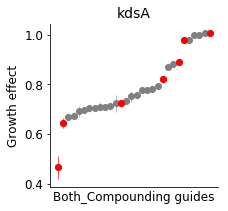

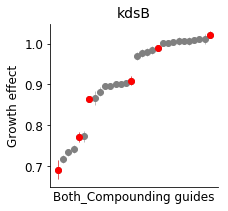

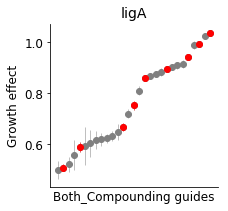

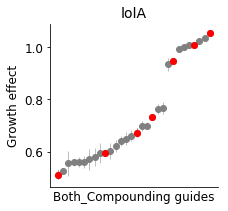

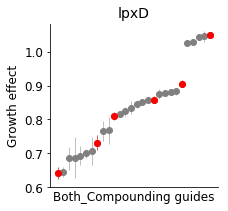

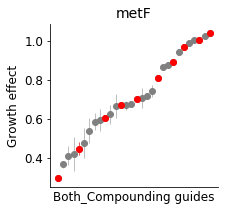

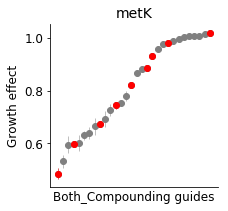

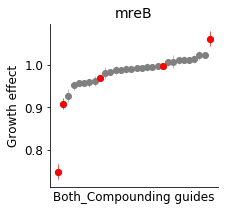

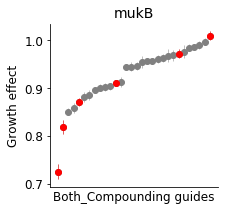

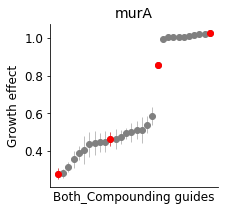

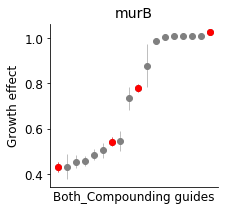

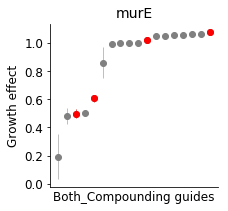

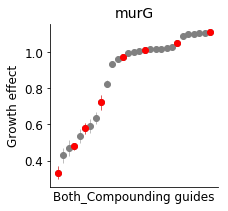

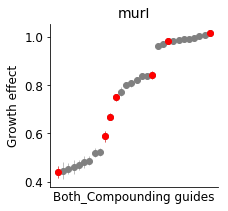

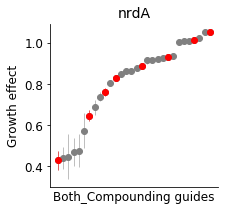

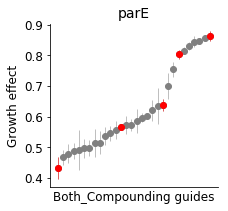

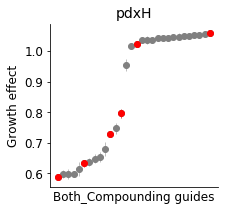

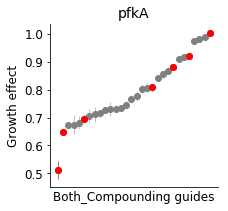

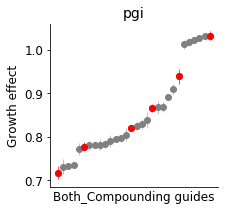

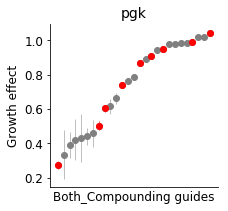

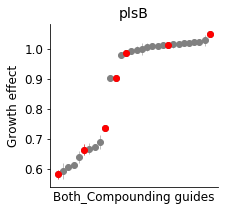

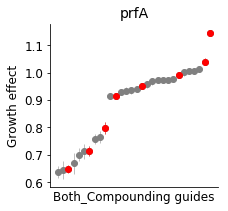

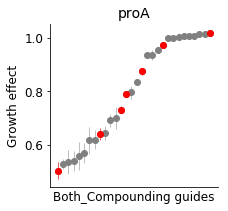

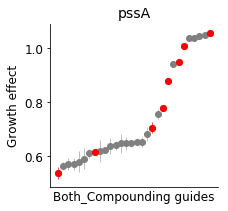

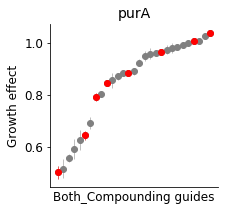

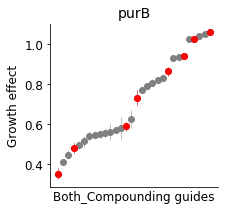

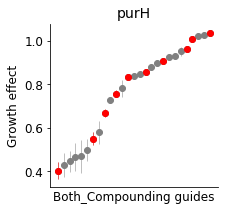

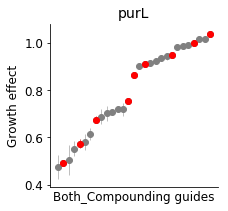

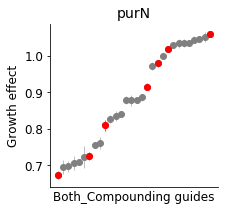

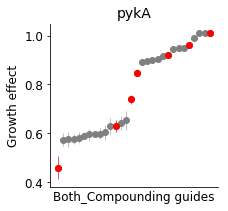

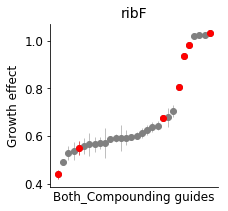

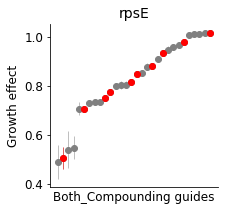

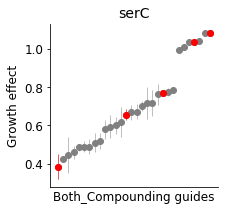

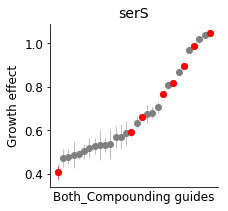

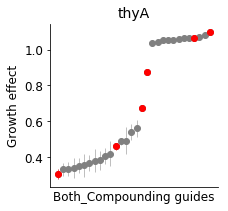

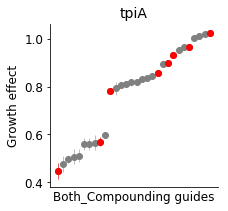

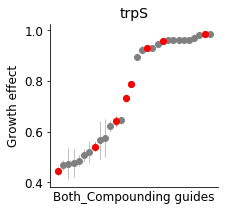

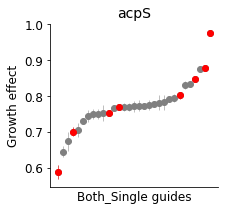

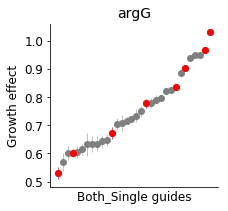

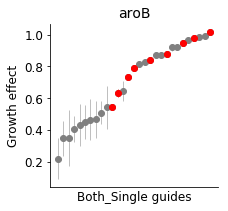

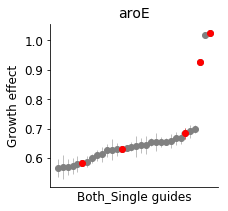

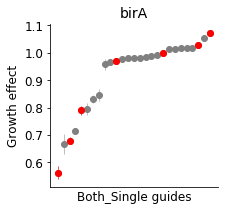

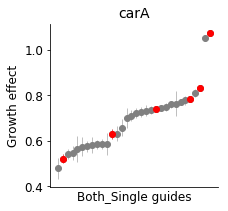

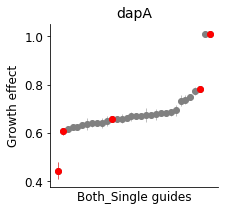

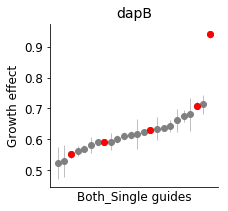

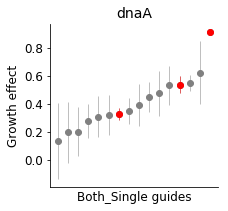

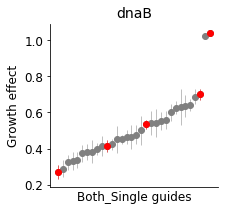

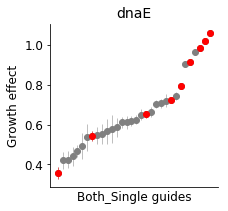

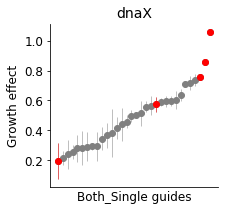

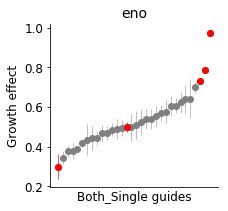

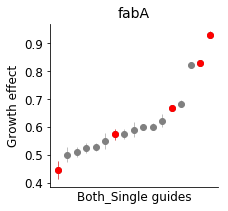

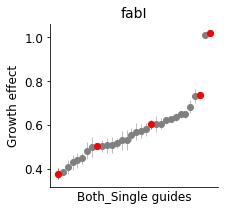

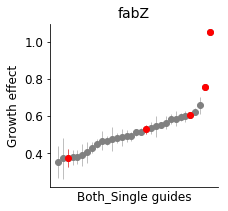

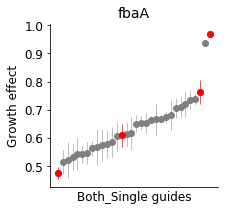

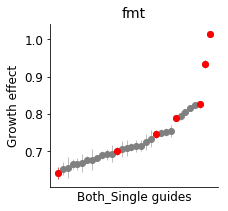

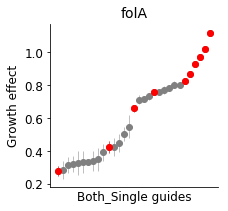

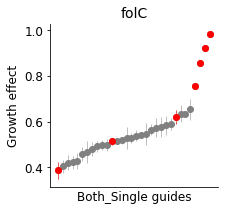

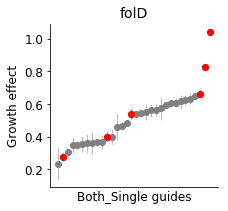

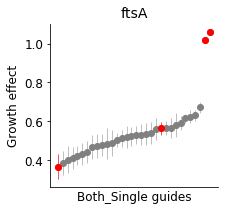

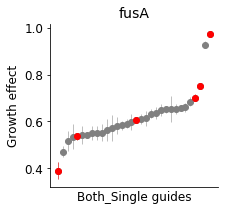

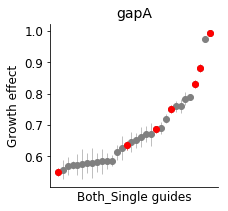

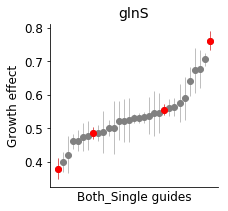

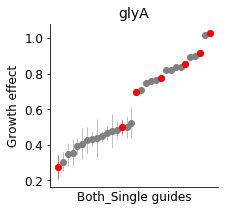

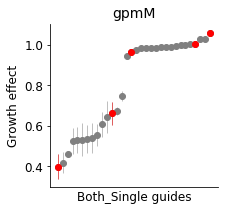

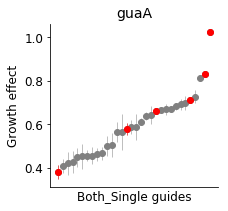

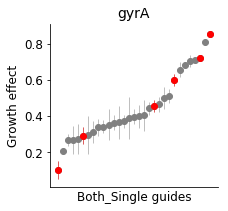

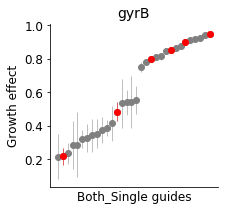

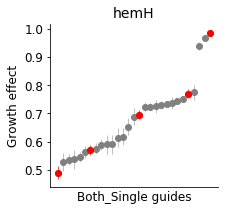

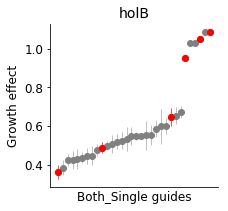

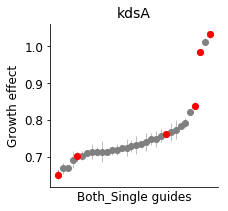

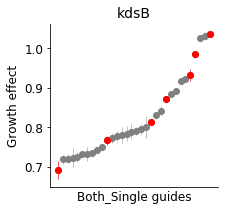

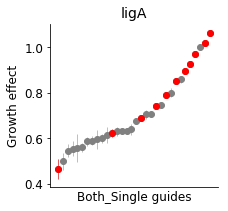

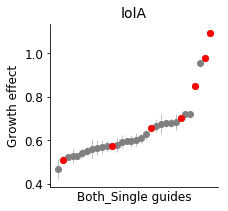

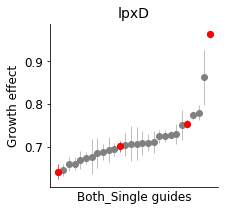

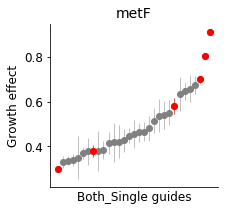

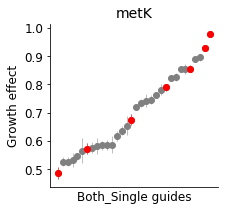

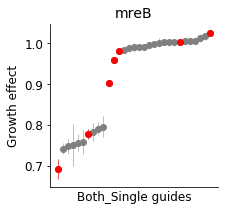

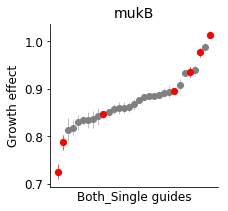

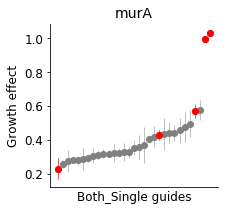

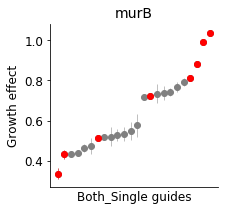

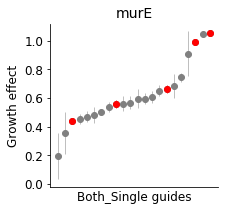

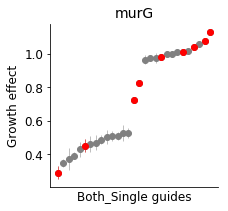

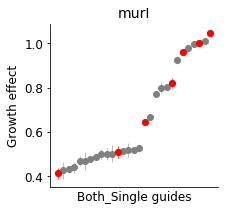

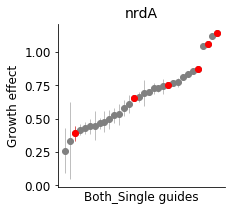

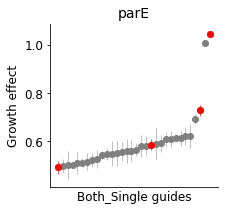

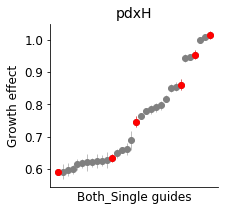

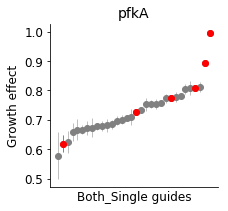

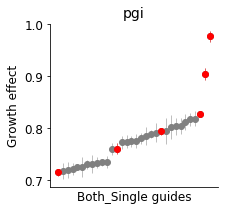

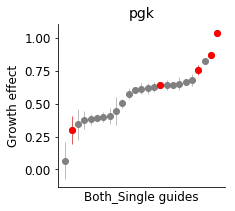

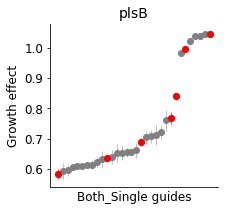

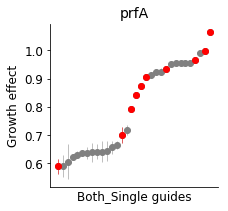

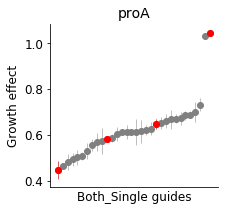

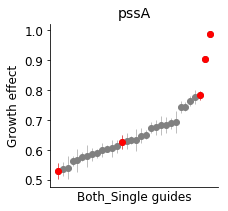

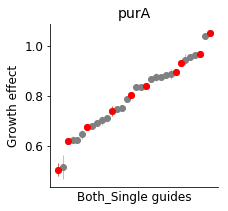

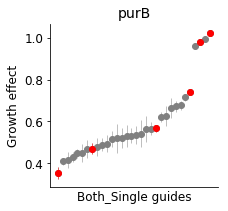

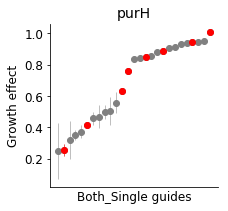

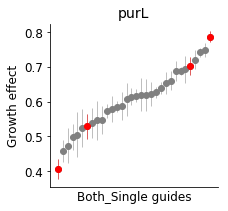

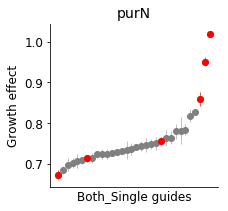

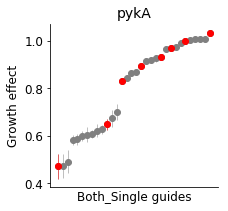

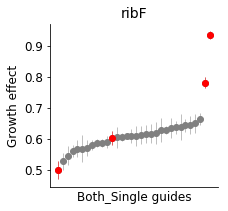

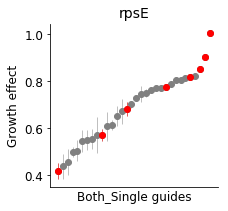

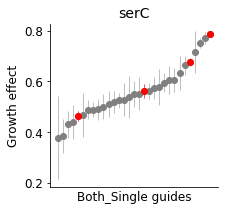

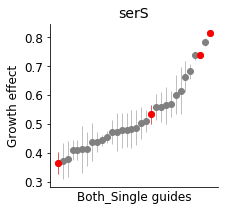

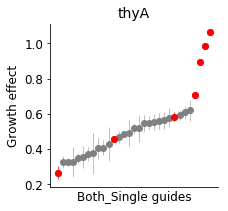

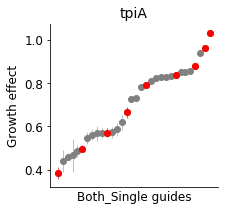

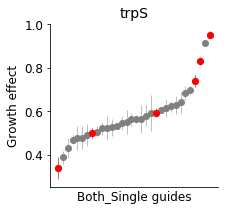

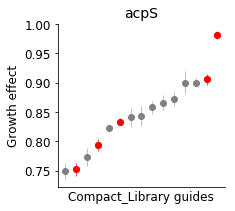

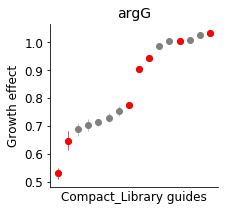

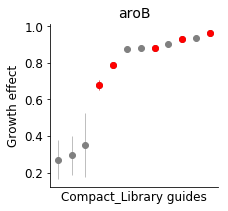

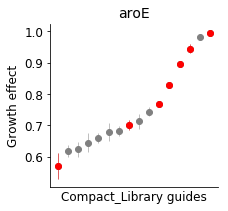

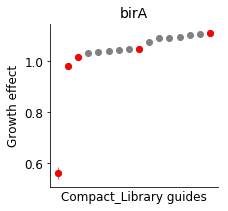

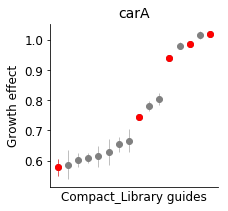

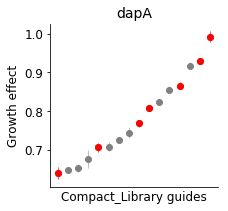

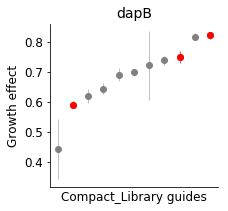

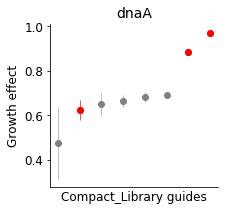

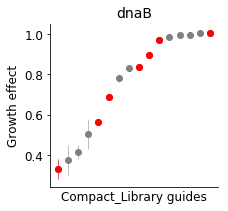

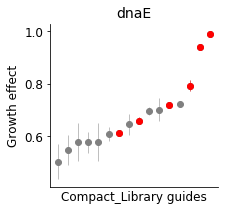

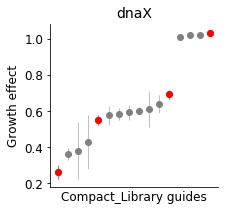

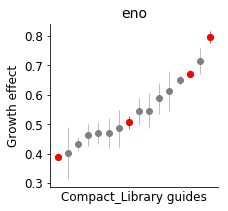

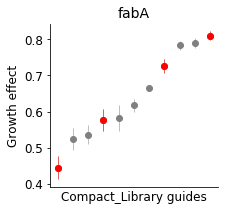

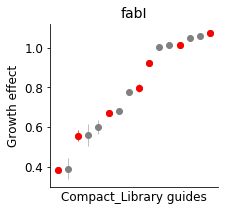

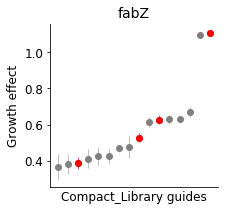

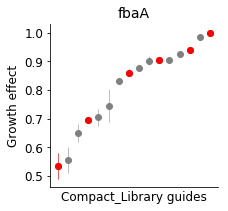

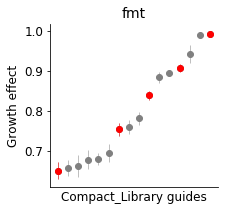

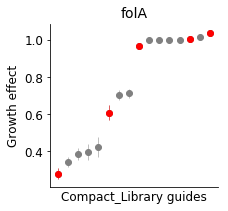

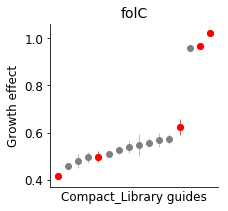

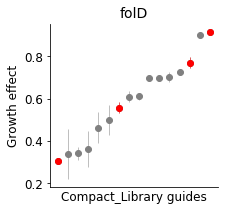

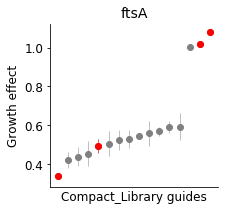

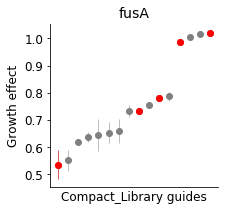

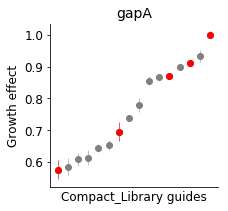

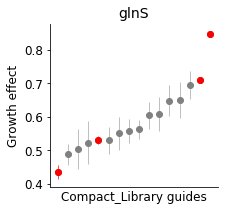

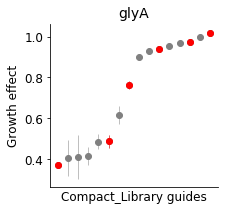

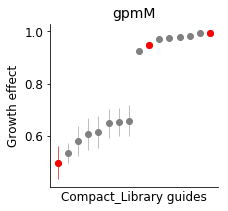

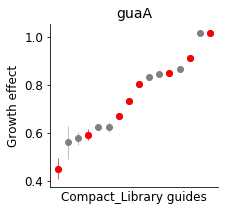

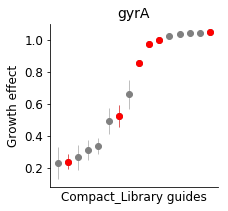

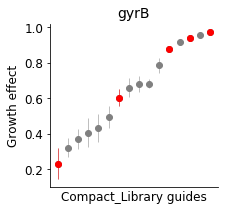

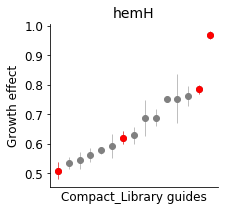

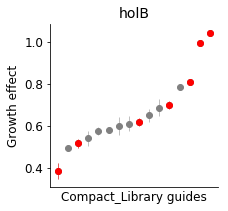

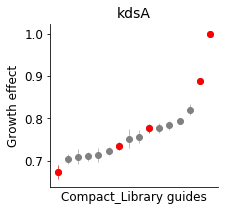

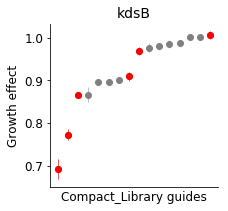

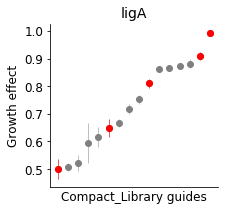

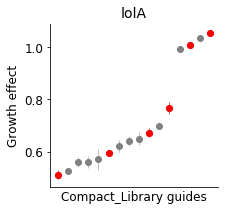

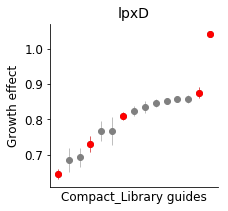

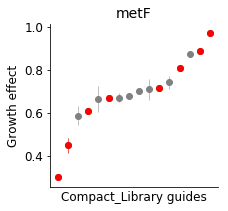

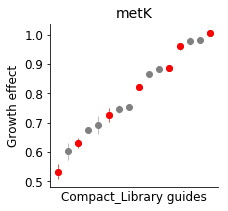

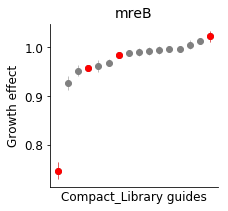

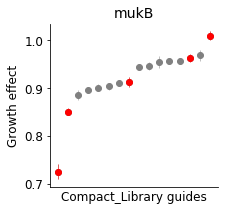

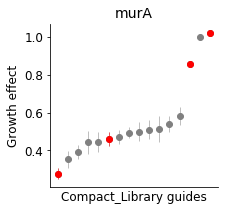

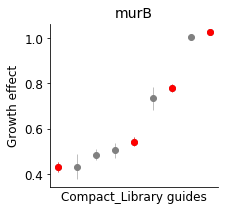

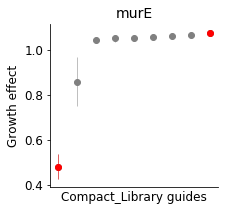

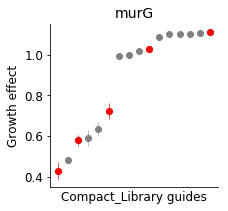

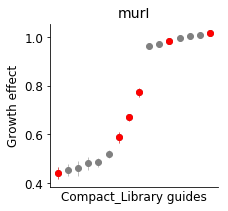

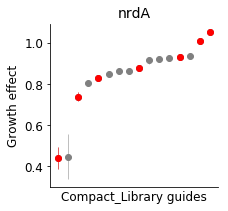

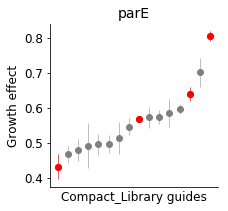

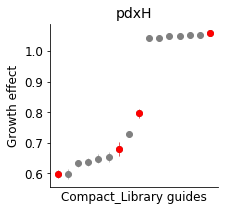

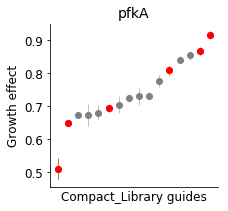

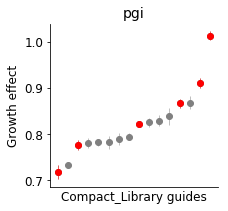

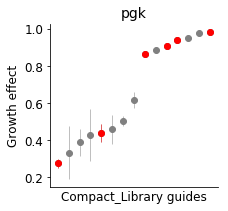

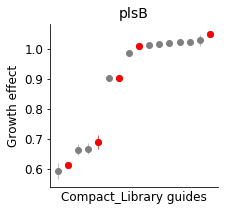

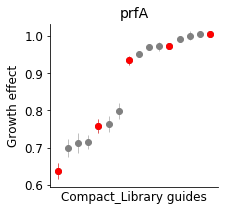

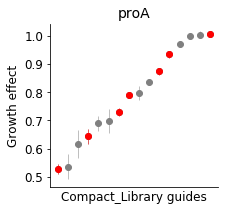

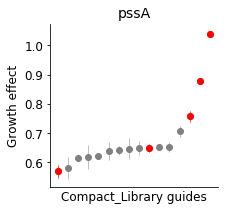

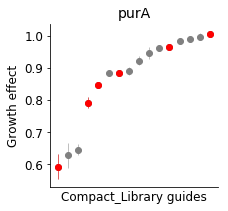

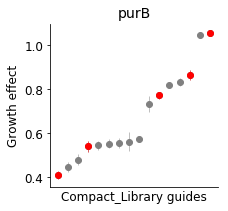

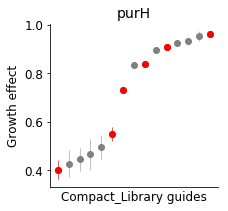

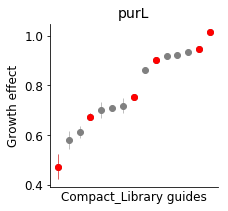

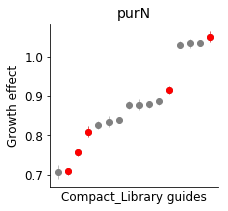

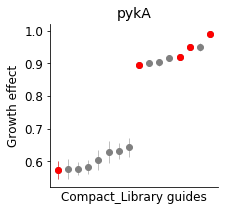

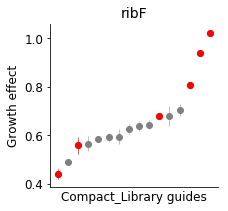

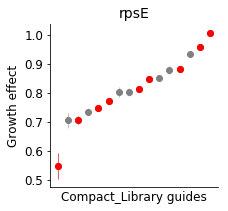

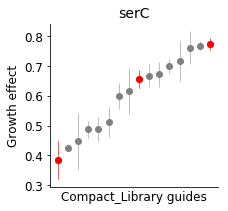

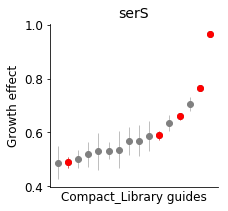

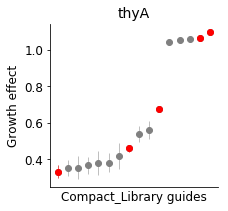

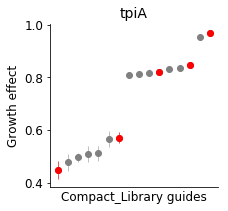

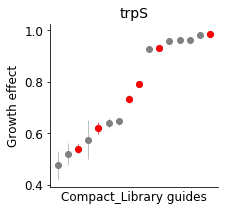

In [20]:
# Figure 4C (folA, Full_All)
for group in group_list:
    best_guide_path[group] = {}
    best_growth_path[group] = {}
    for gene in growth_effect_dict['mean_severe'].index:
        best_guide_path[group][gene], best_growth_path[group][gene] = resolvable_steps(growth_effect_dict, 
                                                                                        guides_dict, max_path, group, 
                                                                                        gene, figure_path, date, True)
        if np.array(best_guide_path[group][gene]).size == 0: # If no guides have measured growth effects for a gene
            del best_guide_path[group][gene]
            del best_growth_path[group][gene]

## Optimal sgRNA paths cover a wide range of growth effects

As seen the plots that can be generated from resolvable_steps, optimal sgRNA paths span nearly all detected growth effects. To visualize where in the range of growth effects our selected guides lie, we pool growth effects across all optimal paths and plot the distribution of growth effects. A trend towards greater growth effects becomes immediately apparent, which can be attributed both to the lower average standard deviation in this regime (allowing for more significant changes in growth effect) and the greater number of guides present in this region in our initial set.

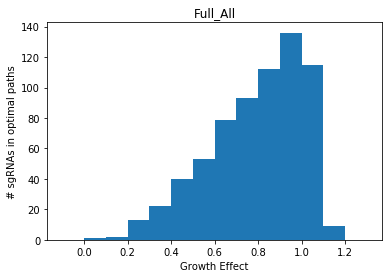

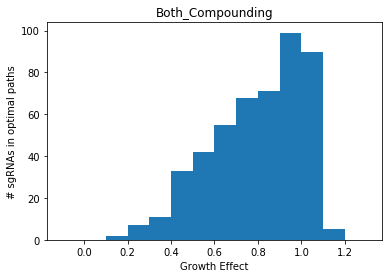

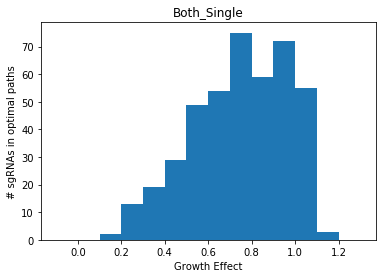

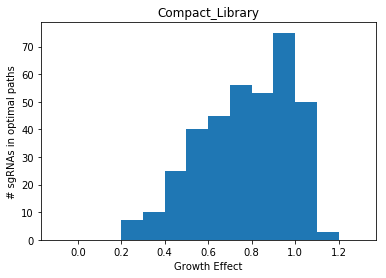

In [21]:
violin_paths = {}
violin_paths_sort = {}
num_eff = {}
min_eff = {}
for group in group_list:

    violin_paths_sort[group] = []
    violin_paths[group] = best_growth_path[group].values()
    num_eff[group] = [len(path) for path in violin_paths[group]]
    min_eff[group] = [min(path) for path in violin_paths[group]]
    min_sort = np.argsort([min(path) for path in violin_paths[group]])
    for idx in min_sort:
        violin_paths_sort[group].append(violin_paths[group][idx])

for group in group_list:
    bins = np.arange(-0.1, 1.4, 0.1)
    plt.hist(np.hstack(violin_paths_sort[group]), bins=bins)
    plt.title(group)
    plt.xlabel('Growth Effect')
    plt.ylabel('# sgRNAs in optimal paths')
    plt.show()

## Distribution of growth effects in optimal paths

One final visualization of the distribution of growth effects from optimal paths is shown below. The x-axis spans all genes investigated, sorted by minimum growth effect. The two colors are present only to better distinguish guides targeting adjacent genes. As stated previously, sgRNAs from these optimal paths span a wide range of growth effects with a bias towards near-WT growth.

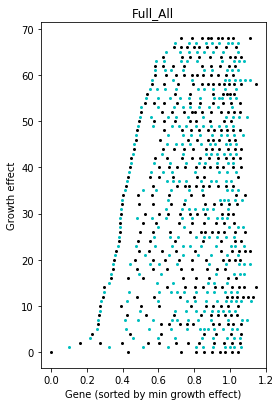

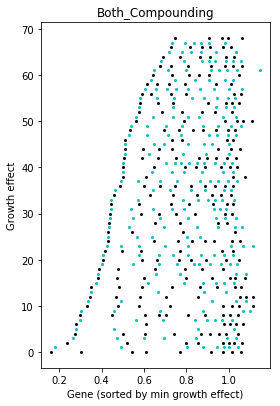

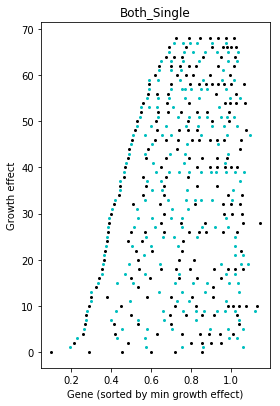

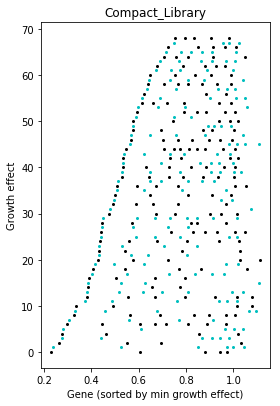

In [22]:
# Figure 4F
for group in group_list:
    plt.figure(figsize = (4, 5.75)) # Initialize figure
    colors = ['k', 'c']*50
    x = np.arange(len(violin_paths_sort[group]))
    for i in np.arange(len(violin_paths_sort[group])):
        x = [i]*len(violin_paths_sort[group][i])
        plt.plot(violin_paths_sort[group][i], x, 'o', color=colors[i], markersize=2)
    plt.title(group)
    plt.xlabel('Gene (sorted by min growth effect)')
    plt.ylabel('Growth effect')
    plt.tight_layout()
    if group == 'Compact_Library':
        plt.savefig(figure_path + date +'_comp_select_Res_' + group + '_Fig4F.pdf', transparent=True)
    else:
        plt.savefig(figure_path + date +'_comp_select_Res_' + group + '.pdf', transparent=True)
    plt.show()